# Imports

In [1]:
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Data Preprocessing

In [2]:
# Define data augmentation and preprocessing for training and validation 
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load and preprocess training and validation data 
train_generator = datagen.flow_from_directory(
    'data/train',
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical'  # Change class_mode to 'categorical'
)
validation_generator = datagen.flow_from_directory(
    'data/valid',
    target_size=(256, 256), 
    batch_size=64,
    class_mode='categorical'  # Change class_mode to 'categorical'
)

# Print class indices
print("Train Label:\n", train_generator.class_indices)
print("Validation Label:\n", validation_generator.class_indices)

Found 6650 images belonging to 7 classes.
Found 1869 images belonging to 7 classes.
Train Label:
 {'100k': 0, '10k': 1, '1k': 2, '20k': 3, '2k': 4, '50k': 5, '5k': 6}
Validation Label:
 {'100k': 0, '10k': 1, '1k': 2, '20k': 3, '2k': 4, '50k': 5, '5k': 6}


# Model Building

In [3]:
# Load pre-trained EfficientNetV2B0
base_model = EfficientNetV2M(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3),
    pooling='max',
    include_preprocessing=True
)

# Add custom classification head with Dropout and L2 Regularization
x = base_model.output
x = Dropout(0.5)(x)  # Add dropout layer
predictions = Dense(7, activation='softmax', kernel_regularizer=l2(0.01))(x)

# Combine base model and custom head
model = Model(inputs=base_model.input, outputs=predictions)

# Make base model layers trainable
for layer in base_model.layers:
    layer.trainable = True

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 256, 256, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 128, 128, 24)      │             648 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 128, 128, 24)      │              96 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 128, 128, 24)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_conv (Conv2D) │ (None, 128, 128, 24)      │           5,184 │ stem_activation[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_bn            │ (None, 128, 128, 24)      │              96 │ block1a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_activation    │ (None, 128, 128, 24)      │               0 │ block1a_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_add (Add)             │ (None, 128, 128, 24)      │               0 │ block1a_project_activatio… │
│                               │                           │                 │ stem_activation[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_conv (Conv2D) │ (None, 128, 128, 24)      │           5,184 │ block1a_add[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_bn            │ (None, 128, 128, 24)      │              96 │ block1b_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_activation    │ (None, 128, 128, 24)      │               0 │ block1b_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_drop (Dropout)        │ (None, 128, 128, 24)      │               0 │ block1b_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_add (Add)             │ (None, 128, 128, 24)      │               0 │ block1b_drop[0][0],        │
│                               │                           │                 │ block1a_add[0][0]          │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 53,159,355 (202.79 MB)

 Trainable params: 52,867,323 (201.67 MB)

 Non-trainable params: 292,032 (1.11 MB)

# Model Training

In [4]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)

# Train the model with callbacks
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    #callbacks=[reduce_lr]
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50


C:\Users\Sakadyk\anaconda3\envs\pi24\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


104/104 ━━━━━━━━━━━━━━━━━━━━ 1287s 11s/step - accuracy: 0.2335 - loss: 4.0152 - val_accuracy: 0.8213 - val_loss: 0.7164 - learning_rate: 1.0000e-04
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1118s 11s/step - accuracy: 0.8733 - loss: 0.5225 - val_accuracy: 0.9128 - val_loss: 0.4357 - learning_rate: 1.0000e-04
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1117s 11s/step - accuracy: 0.9518 - loss: 0.2829 - val_accuracy: 0.9278 - val_loss: 0.4376 - learning_rate: 1.0000e-04
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1124s 11s/step - accuracy: 0.9722 - loss: 0.2193 - val_accuracy: 0.9588 - val_loss: 0.3660 - learning_rate: 1.0000e-04
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1117s 11s/step - accuracy: 0.9829 - loss: 0.1947 - val_accuracy: 0.9572 - val_loss: 0.3680 - learning_rate: 1.0000e-04
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1117s 11s/step - accuracy: 0.9872 - loss: 0.1813 - val_accuracy: 0.9636 - val_loss: 0.3587 - learning_rate: 1.0000e-04
Epoch 7/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1113s 11s/step - 

In [5]:
import json
import pickle

# Simpan data history dari file JSON
with open('history.json', 'w') as f:
    json.dump(history.history, f)

# Simpan data history ke file Pickle
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# Model Evaluation

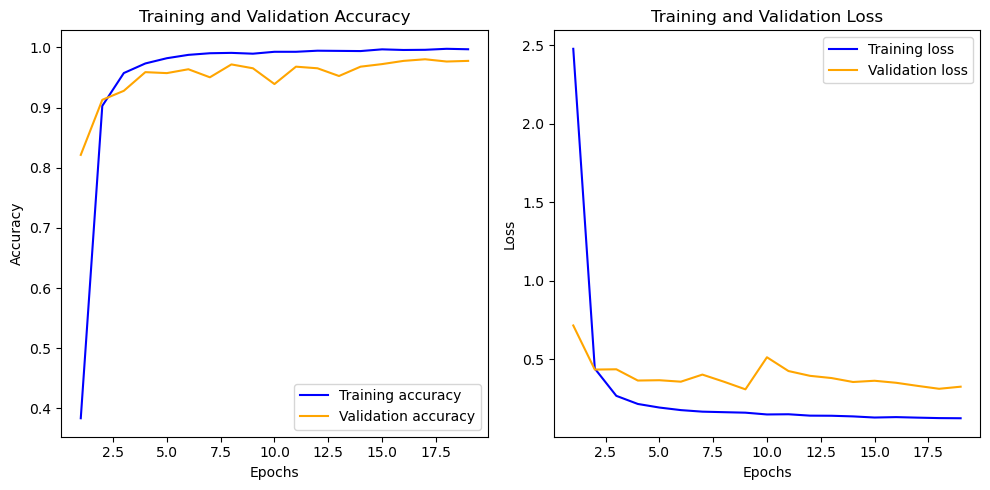

In [6]:
history_dict = history.history

# Extract acc and loss
acc_values = history_dict['accuracy'] 
val_acc_values = history_dict['val_accuracy'] 
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss']

# Get the number of epochs
epochs = range(1, len(acc_values) + 1)

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot the accuracy for training and validation data over epochs
ax[0].plot(epochs, acc_values, label='Training accuracy', color='blue') # Blue Line
ax[0].plot(epochs, val_acc_values, label='Validation accuracy', color='orange') # Orange Line 
ax[0].set_title('Training and Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

#Plot the Loss for training and validation data over epochs
ax[1].plot(epochs, loss_values, label='Training loss', color='blue') # Blue Line
ax[1].plot(epochs, val_loss_values, label='Validation loss', color='orange') # Orange Line 
ax[1].set_title('Training and Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.tight_layout() 
plt.show()

In [7]:
testgen = ImageDataGenerator(
    rescale=1./255
)
test_generator = testgen.flow_from_directory(
    'data/test',
    target_size=(256, 256), 
    batch_size=64,
    class_mode='categorical',  # Change class_mode to 'categorical'
    shuffle=False
)
print("Test Label:\n", test_generator.class_indices)

# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

# Get predictions and true labels
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Print classification report
print('Classification Report')
target_names = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=target_names))

Found 1869 images belonging to 7 classes.
Test Label:
 {'100k': 0, '10k': 1, '1k': 2, '20k': 3, '2k': 4, '50k': 5, '5k': 6}
30/30 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.9103 - loss: 0.5127
Test Loss: 0.6125
Test Accuracy: 88.98%
30/30 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step
Classification Report
              precision    recall  f1-score   support

        100k       1.00      1.00      1.00       267
         10k       1.00      0.84      0.91       267
          1k       0.88      0.85      0.86       267
         20k       0.95      0.91      0.93       267
          2k       0.66      0.94      0.77       267
         50k       0.92      0.82      0.87       267
          5k       0.96      0.87      0.91       267

    accuracy                           0.89      1869
   macro avg       0.91      0.89      0.89      1869
weighted avg       0.91      0.89      0.89      1869



# Model Saving

In [8]:
model.save('model_caps_roy.h5')
# Alternative format
model.save('model_caps_roy.keras')

In [9]:
export_path = 'model_pi_roy'
model.export(export_path)

INFO:tensorflow:Assets written to: model_pi_roy\assets


INFO:tensorflow:Assets written to: model_pi_roy\assets


Saved artifact at 'model_pi_roy'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  2017426236496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2017692369552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2017692369744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2017692370320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2017692369936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2017692371856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2017692371088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2017692370704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2017692371280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2017692372048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2017692374544: TensorSpec(shape=(), dt